# Testing model

In [23]:
from metaspace import SMInstance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from ionimage_embedding.models import CLR
from ionimage_embedding.models.clr.pseudo_labeling import compute_dataset_ublb, pseudo_labeling
from ionimage_embedding.models.clr.utils import size_adaption, size_adaption_symmetric

from sklearn import preprocessing

import umap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sm = SMInstance()

# Kidney

In [3]:
kidney_datasets = [
    '2022-12-07_02h13m50s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s'
                  ]

In [4]:
kidney_results = {}
kidney_images = {}
kidney_if = {}
polarity = '+'

for k in kidney_datasets:
    ds = sm.dataset(id=k)
    results = ds.results(database=("HMDB", "v4"), fdr=0.2).reset_index()
    kidney_results[k] = results
    tmp = ds.all_annotation_images(fdr=0.2, database=("HMDB", "v4"), only_first_isotope=True)
    onsample = dict(zip(results['formula'].str.cat(results['adduct']), ~results['offSample']))
    formula = [x.formula+x.adduct for x in tmp if onsample[x.formula+x.adduct]]
    tmp = np.array([x._images[0] for x in tmp if onsample[x.formula+x.adduct]])
    kidney_images[k] = tmp
    kidney_if[k] = formula

100%|████████████████████████████████████████| 311/311 [00:01<00:00, 268.29it/s]


## Image size adaption

In [5]:
[x.shape for x in kidney_images.values()]

[(245, 74, 84), (221, 88, 88), (194, 41, 78), (237, 56, 85), (276, 71, 82)]

In [6]:
[x.shape for x in size_adaption_symmetric(kidney_images).values()]

[(245, 88, 88), (221, 88, 88), (194, 88, 88), (237, 88, 88), (276, 88, 88)]

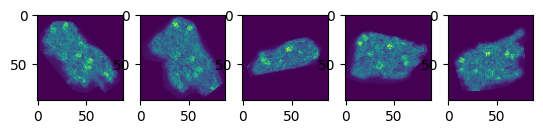

In [7]:
kidney_images_pad = size_adaption(kidney_images)
fig, axs = plt.subplots(ncols=len(kidney_images_pad))
for ax, im in zip(axs, kidney_images_pad):
    ax.imshow(kidney_images_pad[im][0, ::])
plt.show()

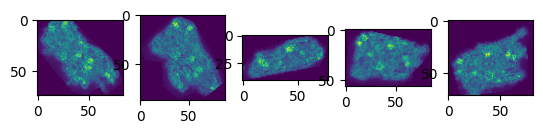

In [8]:
fig, axs = plt.subplots(ncols=len(kidney_images))
for ax, im in zip(axs, kidney_images):
    ax.imshow(kidney_images[im][0, ::])
plt.show()

## Ion overlap

In [9]:
tst = set(kidney_if['2022-12-07_02h13m50s']).intersection(set(kidney_if['2022-12-07_02h13m20s']), 
                                                          set(kidney_if['2022-12-07_02h10m45s']), 
                                                          set(kidney_if['2022-12-07_02h09m41s']), 
                                                          set(kidney_if['2022-12-07_02h08m52s']))

In [10]:
print(f'Intersection of all datasets: {len(tst)}')

Intersection of all datasets: 172


## Build data for training

Required: Dataset id for each image, ion id for each image

In [11]:
training_data = []
training_datasets = [] 
training_ions = []

kidney_images_pad = size_adaption_symmetric(kidney_images)

for dsid, imgs in kidney_images_pad.items():
    
    training_data.append(imgs)
    training_datasets += [dsid] * imgs.shape[0]
    training_ions += kidney_if[dsid]
    
training_data = np.concatenate(training_data)
training_datasets = np.array(training_datasets)
training_ions = np.array(training_ions)

## Training

### Without dataset secific percentiles

In [12]:
model1 = CLR(
            images=training_data,
            dataset_labels=training_datasets,
            ion_labels=training_ions,
            num_cluster=10,
            initial_upper=95,
            initial_lower=20,
            upper_iteration=1,
            lower_iteration=1,
            dataset_specific_percentiles=False,
            knn=True, k=10,
            lr=0.0001, batch_size=100,
            pretraining_epochs=11,
            training_epochs=16,
            cae_encoder_dim=20,
            use_gpu=True,
            random_seed=1224
            )

After 16 epochs, the upper bound will be: 79.
After 16 epochs, the lower bound will be: 36.


In [19]:
cae1, clust1 = model1.train()

CAE Final conv size = 3136
CNNClust final conv dim = 289
Pretraining Epoch: 0 Loss: 0.023337
Pretraining Epoch: 1 Loss: 0.011548
Pretraining Epoch: 2 Loss: 0.009691
Pretraining Epoch: 3 Loss: 0.009101
Pretraining Epoch: 4 Loss: 0.008816
Pretraining Epoch: 5 Loss: 0.008474
Pretraining Epoch: 6 Loss: 0.008185
Pretraining Epoch: 7 Loss: 0.008050
Pretraining Epoch: 8 Loss: 0.007982
Pretraining Epoch: 9 Loss: 0.007913
Pretraining Epoch: 10 Loss: 0.007842
Training Epoch: 0 Loss: 0.023900
Training Epoch: 1 Loss: 0.012747
Training Epoch: 2 Loss: 0.010928
Training Epoch: 3 Loss: 0.010189
Training Epoch: 4 Loss: 0.009523
Training Epoch: 5 Loss: 0.009445
Training Epoch: 6 Loss: 0.009325
Training Epoch: 7 Loss: 0.009183
Training Epoch: 8 Loss: 0.009282
Training Epoch: 9 Loss: 0.008878
Training Epoch: 10 Loss: 0.008987
Training Epoch: 11 Loss: 0.008560
Training Epoch: 12 Loss: 0.008586
Training Epoch: 13 Loss: 0.008818
Training Epoch: 14 Loss: 0.008844
Training Epoch: 15 Loss: 0.008565


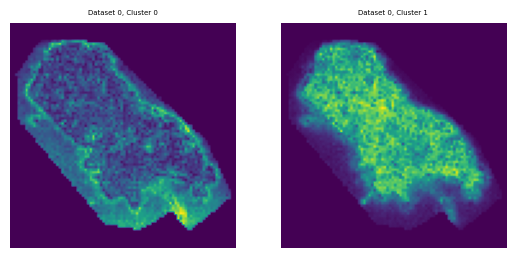

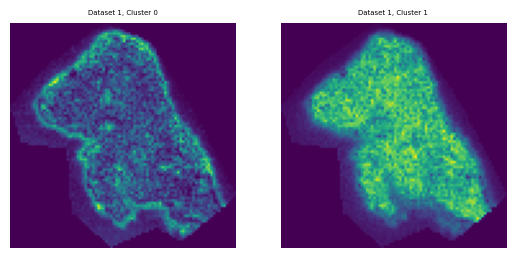

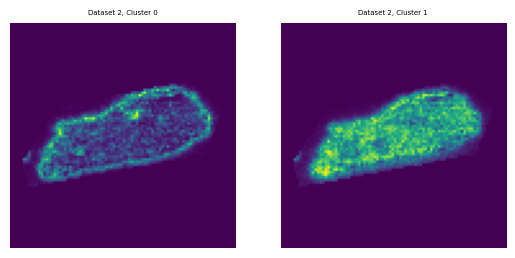

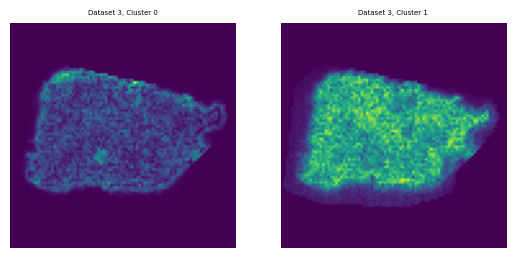

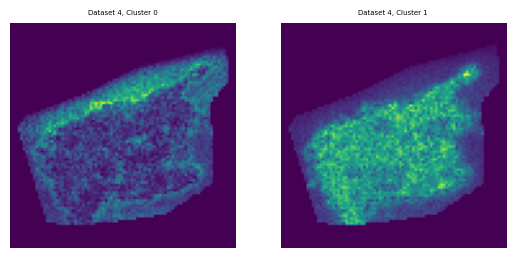

In [20]:
pred_labels1 = model1.inference(cae1, clust1)

# Loop over datasets:
ds_counter = 0
for ds in kidney_datasets:
    
    ds_imgs = model1.image_data[model1.dataset_labels==ds]
    curr_labels = pred_labels1[model1.dataset_labels==ds]
    
    cluster_ion_images = []
    for cluster in set(pred_labels1):
        tmp = np.mean(ds_imgs[curr_labels==cluster], axis=0)
        cluster_ion_images.append(tmp)
    fig, axs = plt.subplots(ncols=len(set(pred_labels1)))
    counter = 0
    for ax, im in zip(axs, cluster_ion_images):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Dataset {ds_counter}, Cluster {counter}', fontdict={'fontsize': 5})
        counter += 1
    plt.show()
    ds_counter += 1


### With dataset specific percentiles

In [13]:
model = CLR(
            images=training_data,
            dataset_labels=training_datasets,
            ion_labels=training_ions,
            num_cluster=8,
            initial_upper=93,
            initial_lower=37,
            upper_iteration=1.5,
            lower_iteration=1.5,
            dataset_specific_percentiles=True,
            knn=True, k=5,
            lr=0.0001, batch_size=128,
            pretraining_epochs=11,
            training_epochs=16,
            cae_encoder_dim=20,
            use_gpu=True,
            random_seed=1224
            )

After 16 epochs, the upper bound will be: 69.0.
After 16 epochs, the lower bound will be: 61.0.


In [14]:
cae, clust = model.train()

CAE Final conv size = 3136
CNNClust final conv dim = 289
Pretraining Epoch: 0 Loss: 0.021705
Pretraining Epoch: 1 Loss: 0.007243
Pretraining Epoch: 2 Loss: 0.006085
Pretraining Epoch: 3 Loss: 0.005632
Pretraining Epoch: 4 Loss: 0.005346
Pretraining Epoch: 5 Loss: 0.005179
Pretraining Epoch: 6 Loss: 0.005070
Pretraining Epoch: 7 Loss: 0.004939
Pretraining Epoch: 8 Loss: 0.004826
Pretraining Epoch: 9 Loss: 0.004747
Pretraining Epoch: 10 Loss: 0.004657
Training Epoch: 0 Loss: 0.034472
Training Epoch: 1 Loss: 0.033163
Training Epoch: 2 Loss: 0.033437
Training Epoch: 3 Loss: 0.027672
Training Epoch: 4 Loss: 0.016386
Training Epoch: 5 Loss: 0.014372
Training Epoch: 6 Loss: 0.013454
Training Epoch: 7 Loss: 0.012996
Training Epoch: 8 Loss: 0.013253
Training Epoch: 9 Loss: 0.012652
Training Epoch: 10 Loss: 0.012793
Training Epoch: 11 Loss: 0.012503
Training Epoch: 12 Loss: 0.012834
Training Epoch: 13 Loss: 0.012192
Training Epoch: 14 Loss: 0.012489
Training Epoch: 15 Loss: 0.012510


/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


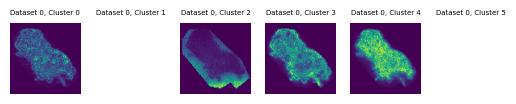

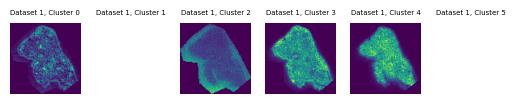

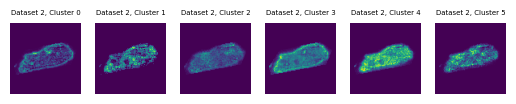

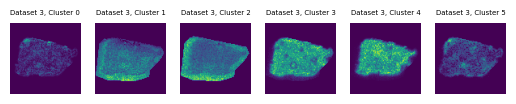

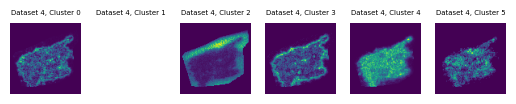

In [15]:
pred_labels = model.inference(cae, clust)

# Loop over datasets:
ds_counter = 0
for ds in kidney_datasets:
    
    ds_imgs = model.image_data[model.dataset_labels==ds]
    curr_labels = pred_labels[model.dataset_labels==ds]
    
    cluster_ion_images = []
    for cluster in set(pred_labels):
        cluster_ion_images.append(np.mean(ds_imgs[curr_labels==cluster], axis=0))
    fig, axs = plt.subplots(ncols=len(set(pred_labels)))
    counter = 0
    for ax, im in zip(axs, cluster_ion_images):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Dataset {ds_counter}, Cluster {counter}', fontdict={'fontsize': 5})
        counter += 1
    plt.show()
    ds_counter += 1
